
## MDS and Random Forest Investigation of the Impact of the Properties of Active Oils on the Solublization Ratio of Phase Behavior Experiments

#### Miguel Mejia
#### Hildebrand Department of Petroleum and Geosystems Engineering, UT Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

This workflow uses the properties of active oils to look for relationships between those properties and the solubilization ratios (SR) of phase behavior experiments, it would be useful to know if some oil properties are related to the SR, as this might reduce the number of experiments required to design a surfactant EOR formulation. Multi-dimensional scaling and random forests were used in this study to determine if the oil properties have a distinct impact on the SR. What was learned is extremely interesting: there is no obvious relationship between the physical oil properties and SR measurements. If there had been an obvious relationship between the oil properties and SR, this would've been very, very valuable. A random forest with a depth of 5 and 500 trees did not yield a useful relationship either; however, a forest with a depth of 30 and 500 trees did (and this is obviously an overfit).The recommendations from this work are that surfactant and brine properties are necessary for accurate predictions of SR; which means including at least another set of 20+ parameters per experiment since surfactants are complex molecules with many descriptors.

### Important announcement on code reuse
This workflow uses Dr. Pyrcz' MDS worflow as a backbone, since I am not too adept at coding. The source of Dr. Pyrcz' work is found here: 
https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Multidimensional_Scaling.ipynb

and his workflow on random forests is here:
https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_EnsembleTrees.ipynb

### Import Packages


In [95]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import seaborn as sns                     # for matrix scatter plots
from sklearn.manifold import MDS          # multidimensional scaling
from sklearn.metrics.pairwise import euclidean_distances  # for multidimensional scaling distance comparison

### Load Data

Load the data to a Pandas' DataFrame object. 

The data is not actual experimental data, it consists of 300 bootstrapped samples from about 100 original experiments. 
The features are normalized and include: 
- oil molecular weight, 
- oil equivalent alkane carbon number, 
- oil molar volume, oil density, 
- oil total acid number, 
- experiment solubilization ratio.

The bootstrap approach consisted of the following code: 
```python
L = 300                                                  # set the number of realizations for uncertainty calculation
cols = df_variables.shape[1]
mean = np.zeros((L,cols)); stdev = np.zeros((L,cols))    # declare arrays to hold the realizations of the statistics
                     
for l in range(0, L):                                    # loop over realizations
    samples = df_variables.sample(len(df_variables),replace=True).values

    mean[l] = samples.mean(axis=0)

df_bootstrap = pd.DataFrame(mean, columns = df_variables.columns)
```

In [98]:
df = pd.read_csv('PGE383_Project_Miguel_Mejia_data.csv')      # load our data table 

### Basic Data Checking and Visualization

Look at the summary of the data to try and find unreal values or linear relationships.

In [99]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NS_MW,300.0,-0.004049,0.094264,-0.300716,-0.058284,-0.005456,0.063644,0.249029
NS_EACN,300.0,-0.008235,0.091606,-0.268349,-0.071852,-0.017146,0.054143,0.311374
NS_Vm,300.0,-0.005523,0.093862,-0.310806,-0.058414,-0.010845,0.061898,0.250874
NS_density,300.0,0.007096,0.090826,-0.308074,-0.054358,0.005326,0.069359,0.343159
NS_TAN,300.0,0.004575,0.090142,-0.264053,-0.056076,0.005053,0.063154,0.246236
NS_SR,300.0,-0.001201,0.098817,-0.305416,-0.067977,-0.003213,0.078150,0.248423


The dataframe looks good, in fact, I already checked the data to make sure this was the case. I'll make a shallow copy of the dataframe called df_continuous_variables and keep going from there.

In [100]:
df_continuous_variables = df
df_continuous_variables.describe()

,NS_MW,NS_EACN,NS_Vm,NS_density,NS_TAN,NS_SR
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,-0.004049,-0.008235,-0.005523,0.007096,0.004575,-0.001201
std,0.094264,0.091606,0.093862,0.090826,0.090142,0.098817
min,-0.300716,-0.268349,-0.310806,-0.308074,-0.264053,-0.305416
25%,-0.058284,-0.071852,-0.058414,-0.054358,-0.056076,-0.067977
50%,-0.005456,-0.017146,-0.010845,0.005326,0.005053,-0.003213
75%,0.063644,0.054143,0.061898,0.069359,0.063154,0.078150
max,0.249029,0.311374,0.250874,0.343159,0.246236,0.248423


Lets look at the correlation matrix and see if we find strongly correlated variables.

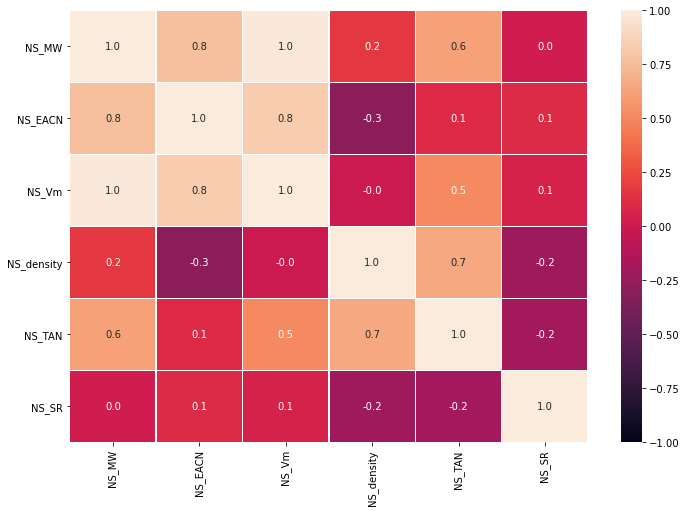

In [101]:
plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(df_continuous_variables.corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f', annot=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

It looks like the solubilization ratio does not have a strong correlation with any of the oil properties. Lets look at the pairplot with all the variables to observe bivariate relationships.

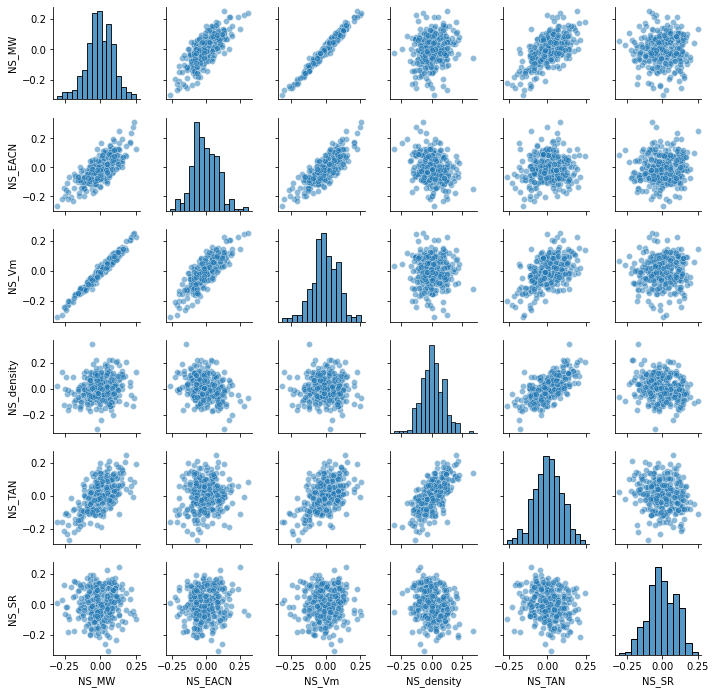

In [102]:
sns.pairplot(df_continuous_variables,markers='o',plot_kws={'alpha': 0.5})
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.6, wspace=0.3, hspace=0.2)
plt.show()

The bivariate plots confirm the lack of an obvious relationship between any of the oil properties and the solubilization ratio. The oil properties themselves (MW-Vm) have strong relationships, but that is not surprishing at all, since they are basically analogues in some respects. The interesting one is the apparent relationship between the TAN and the density, and TAN and MW, I did not expect them to be as related as they are.

### Name of My Workflow: MDS and RF patterns between the properties of active oils and solubilization ratios

This workflow uses multidimensional scaling and random forests to try to predict the solubilization ratios of phase behavior experiments from several oil properties.


### 1. Create an ordinal feature

Let's make an ordinal feature from the continuous solubilization ratio:

1. low
2. medium
3. high
4. very high 

This will help us visualize the results, we will look at experiments with different solubilization ratios projected into a lower dimensional space with multidimensional scaling.

In [103]:
bins = [-.2,-0.05,0.01,0.07,0.35]                
labels = ['low', 'med', 'high', 'vhigh']       # assign the labels
category = pd.cut(df_continuous_variables['NS_SR'],bins,labels=labels)     # make the 1D array with the labels for our data
df_continuous_variables['tSR'] = category                                # add the new ordinal production feature to our DataFrames    
df_continuous_variables.head()


,NS_MW,NS_EACN,NS_Vm,NS_density,NS_TAN,NS_SR,tSR
0,0.066093,0.151270,0.068795,-0.010220,-0.064220,0.061668,high
1,0.081763,0.076833,0.083475,0.002036,0.101371,0.067151,high
2,0.038703,0.015342,0.028004,0.082274,-0.004646,-0.016797,med
3,-0.205916,-0.201116,-0.203543,-0.027453,-0.014037,0.116719,vhigh
4,-0.033955,-0.010496,-0.024938,-0.071347,0.004508,-0.067618,low


Show the matrix scatter plot of our features and the solubilization ratio designations.

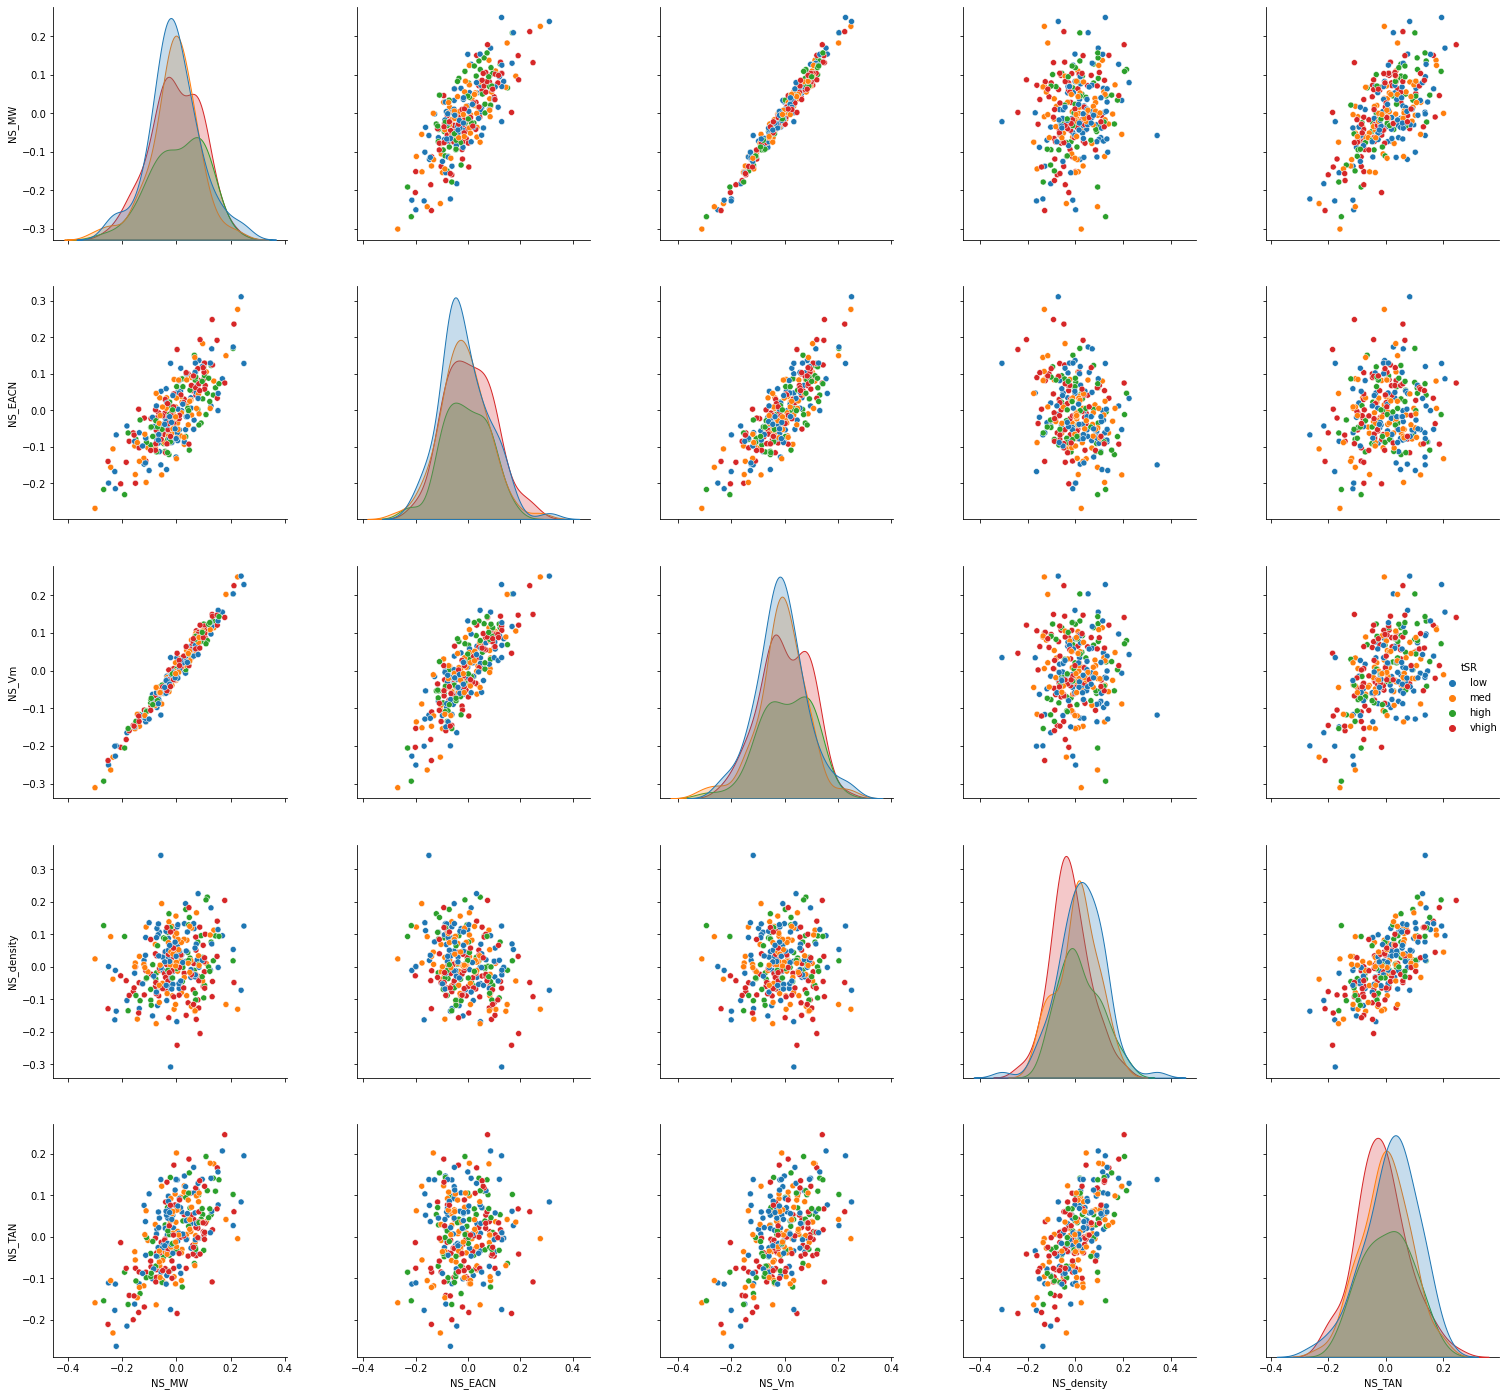

In [104]:
sns.pairplot(df_continuous_variables.drop(columns=['NS_SR']),markers='o',hue = 'tSR')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.3, hspace=0.2)
plt.show()

Super interesting, the high and low solubilization ratios are all over the place! What does that mean? Well, that an active oil is not necessarily good or bad for chemical EOR depending on the features selected. Most likely, something else must be taken into account.

### 2. Multidimensional scaling

Let's run multidimensional scaling on our subset of features ($m = 4$) and project to only 2 features ($p = 2$). If there's a clear transition in 2 dimensions, we can use the MDS axes to make predictions on SR.

In [105]:
np.random.seed(2)                               # set the random number seed
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2)                    # instantiate and set the hyperparameter
MDS_transformed = embedding.fit_transform(df_continuous_variables.drop(columns=['tSR','NS_SR']))

The output is 2 multidimensional scaling components.  We have projected our 4 features to 2 features to minimize the error in pairwise distance between the samples.  Let's add the 2 components to our DataFrame.

In [106]:
df_continuous_variables['MDS1'] = MDS_transformed[:,0]
df_continuous_variables['MDS2'] = MDS_transformed[:,1]
df_continuous_variables.head()

,NS_MW,NS_EACN,NS_Vm,NS_density,NS_TAN,NS_SR,tSR,MDS1,MDS2
0,0.066093,0.151270,0.068795,-0.010220,-0.064220,0.061668,high,-0.112580,-0.165732
1,0.081763,0.076833,0.083475,0.002036,0.101371,0.067151,high,0.035442,-0.174599
2,0.038703,0.015342,0.028004,0.082274,-0.004646,-0.016797,med,0.045948,-0.055370
3,-0.205916,-0.201116,-0.203543,-0.027453,-0.014037,0.116719,vhigh,0.011988,0.345149
4,-0.033955,-0.010496,-0.024938,-0.071347,0.004508,-0.067618,low,-0.063940,0.024397


Look at the samples projected into the new 2 dimensional feature space.  

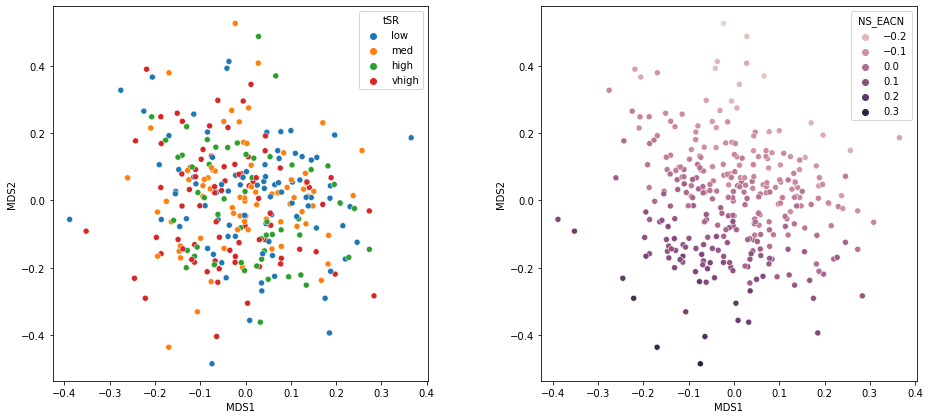

In [107]:
plt.subplot(121)
pairplot = sns.scatterplot(x = df_continuous_variables['MDS1'],y = df_continuous_variables['MDS2'],hue = df_continuous_variables['tSR'],markers='o')

plt.subplot(122)
pairplot = sns.scatterplot(x = df_continuous_variables['MDS1'],y = df_continuous_variables['MDS2'],hue = df_continuous_variables['NS_EACN'],markers='o')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.3, wspace=0.3, hspace=0.2)
plt.show()

Some comments:

* There is no clear transition from low to high solubilization ratio in lower dimensional space (or for bivariate plots in higher dimensional space). Samples with any of the 4 labels of SR are scattered all throughout the MDS1 vs MDS2 map, there is no clear order.


Let's check the model:

* Calculate the original and projected pairwise distances between all the samples

* Cross plot the original vs the projects pairwise distances

* Plot the distribution of the ratio between projects / original pariwise distances


Distance Ratio, mean: 0.68, standard deviation 0.07.


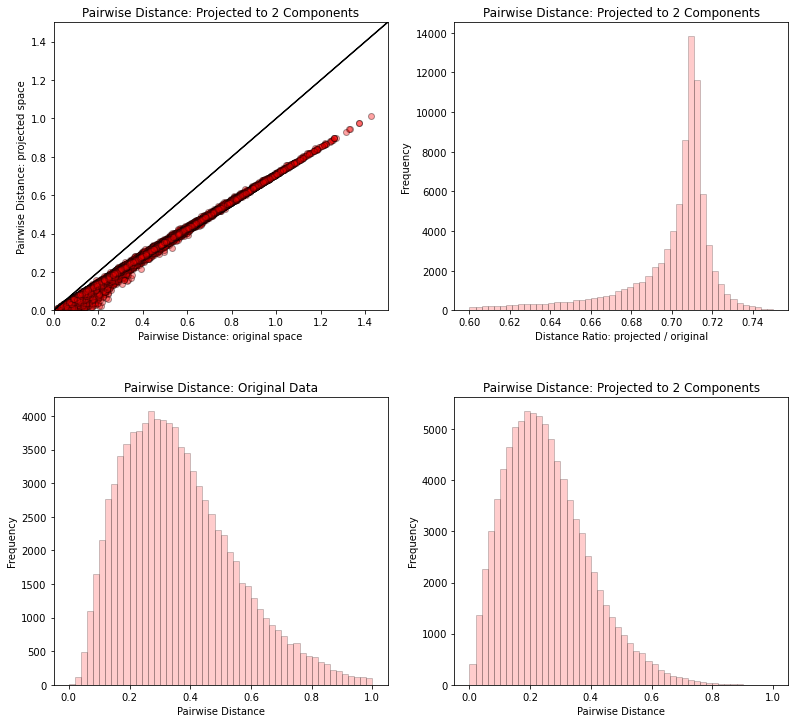

In [108]:
dists = euclidean_distances(df_continuous_variables.drop(columns=['tSR','NS_SR']), squared=False).ravel()
nonzero = dists != 0   # select only non-identical samples pairs
dists = dists[nonzero]
projected_dists = euclidean_distances(MDS_transformed, squared=False).ravel()[nonzero]

plt.subplot(221)
plt.scatter(dists,projected_dists,c='red',alpha=0.2,edgecolor = 'black')
plt.arrow(0,0,1.5,1.5,width=0.0025,color='black',head_length=0.0,head_width=0.0)
plt.xlim(0,1.5); plt.ylim(0,1.5)
plt.xlabel("Pairwise Distance: original space")
plt.ylabel("Pairwise Distance: projected space")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

rates = projected_dists / dists
print("Distance Ratio, mean: %0.2f, standard deviation %0.2f." % (np.mean(rates), np.std(rates)))

plt.subplot(222)
plt.hist(rates, bins=50, range=(.6,0.75),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Distance Ratio: projected / original")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplot(223)
plt.hist(dists, bins=50, range=(0,1),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Original Data")

plt.subplot(224)
plt.hist(projected_dists, bins=50, range=(0,1),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=2.3, wspace=0.2, hspace=0.3)
plt.show()

Interesting, the pairwise distance with two components is lower than the pairwise distance with 4 components.

### 3. Random forest
Let's try a random forest regressor for feature importance and feature prediction and see if we can predict SR out of oil property data using a different approach to MDS.

Feature ranking:
1. feature 4 (0.247648)
2. feature 3 (0.241368)
3. feature 1 (0.209625)
4. feature 2 (0.158297)
5. feature 0 (0.143063)


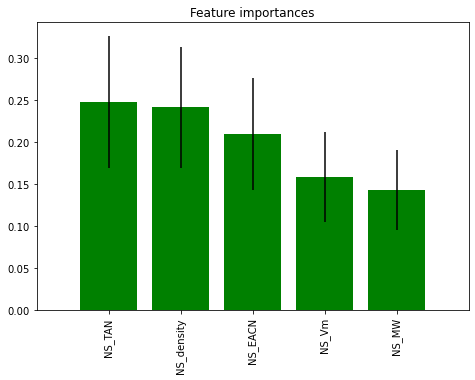

In [109]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')     

x = df.iloc[:,[0,1,2,3,4]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[5]]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest = RandomForestRegressor()   # instantiate the random forest  
random_forest = random_forest.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest.feature_importances_ # extract the expected feature importances
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

It's interesting that the density shows such a high relevance to the SR with the random forest regressor. Typical models use the EACN and the TAN. Density is much, much easier to measure in the lab, so that is useful. 
    Lets try a random forest model to predict the SR from the oil properties. The first model contains 500 trees with a depth of 5 and is shown on the left plot. It yields an almost horizontal line, a weak prediction. From the previous anlayses, this was pretty much expected. 
    Of course, we can make the model much more complex (overfit) and make it appear as if the oil properties can actualy be used to predict SR. The second plot to the right does the same, but now increases the tree depth to 20. It looks like we got something, but did we? I would certainly not say confidently that a specific oil will give you some SR due to its properties based on this model.

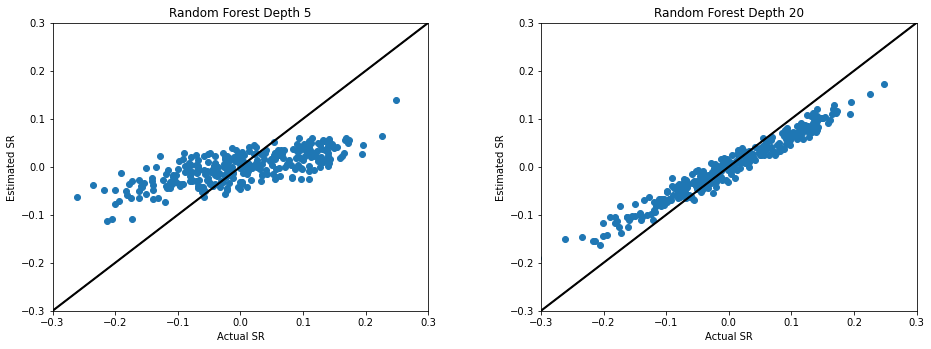

In [111]:
from sklearn import metrics                                 # measures to check our models
import math                                                 # basic calculations like square root
seed = 2                                                    # set the random forest hyperparameters
max_depth = 5
max_depth2 = 20
num_tree = 500
max_features = 1

my_first_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features)
my_second_forest = RandomForestRegressor(max_depth=max_depth2, random_state=seed,n_estimators=num_tree, max_features=max_features)

my_first_forest.fit(X = x, y = y)           # train the model with training data 
my_second_forest.fit(X = x, y = y)           # train the model with training data 
predict_train = my_first_forest.predict(x)
predict_train2 = my_second_forest.predict(x)
# plt.subplot(121)                                            # predict with the model over the predictor feature space and visualize

plt.subplot(121)                                            # perform cross validation with withheld testing data
plt.scatter(y,predict_train)
plt.title('Random Forest Depth 5'); plt.xlabel('Actual SR'); plt.ylabel('Estimated SR')
plt.xlim(-0.3,0.3); plt.ylim(-0.3,0.3)
plt.arrow(-0.3,-0.3,1,1,width=0.002,color='black',head_length=0.0,head_width=0.0)

plt.subplot(122)                                            # perform cross validation with withheld testing data
plt.scatter(y,predict_train2)
plt.title('Random Forest Depth 20'); plt.xlabel('Actual SR'); plt.ylabel('Estimated SR')
plt.xlim(-0.3,0.3); plt.ylim(-0.3,0.3)
plt.arrow(-0.3,-0.3,1,1,width=0.002,color='black',head_length=0.0,head_width=0.0)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.2)

### Results

This workflow shows that oil properties alone are likely a poor predictor for the solubilization ratio of phase behavior experiments. Bivariate plots and a correlation matrix of the properties showed this was the case. Two oils with similar properties may have very different SR in their respective experiments. Neither multidimensional scaling, nor random forests, were successful in using the oil properties to predict the SR without overfitting. The SR is then a function of the interaction between the specific oil, the surfactants with their distinct chemical characteristics and interactions, and brine and its characteristics. This is actually encouraging, since it means that we can engineer a high-performing chemical formulation for the oil, and not be limited by the natural properties of the oil itself.

### Parting comments

Miguel is a phd student working on fluid optimization of chemicals for enhanced oil recovery in fractured carbonate formations with low permeability. His advisors are Dr. Gary Pope and Dr. Matt Balhoff. Miguel does coreflood experiments, runs numerical simulations with The University of Texas at Austin Chemical Simulator (UTCHEM) and is a student in Dr. Michael Pyrcz' machine learning course, where he has learned to combine machine learning algorithms with experimental results to build data driven models for microemulsion phase behavior prediction. 